Test if all-to-all inhibition creates the desired MEG response

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes

# Baselines

In [140]:
seed = 8
t_pause = 0.8
t_present = 0.3
t_each = t_pause + t_present
dt = 0.001

td_pause = t_pause/dt

## 2D

In [161]:
n_items = 16
dimensions = 2
n_neurons = 100

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=10)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=11)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=12)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=13)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=14)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/vocab.py:102: UserWarning: Could not create a semantic pointer with max_similarity=0.90 (D=2, M=15)
  len(self.pointers)))
/home/saubin/git/nengo_spa/nengo_spa/voc

In [162]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
len(feed_vecs)

32

In [163]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e3

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(paused, ens.neurons, transform=-1 * np.ones((n_neurons, 1)))
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:15.                                                 


In [164]:
fan1_slc = slice(int(td_pause), int(t_each/dt)*len(fan1)+int(td_pause))
fan2_slc = slice(fan1_slc.stop, int(t_each/dt)*len(feed_vecs)+int(td_pause))

In [165]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

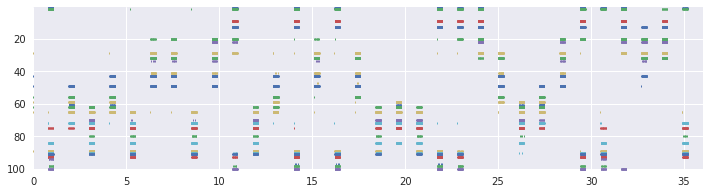

In [166]:
plt.figure(figsize=(12, 3))
rasterplot(sim.trange(), sim.data[p_spikes])

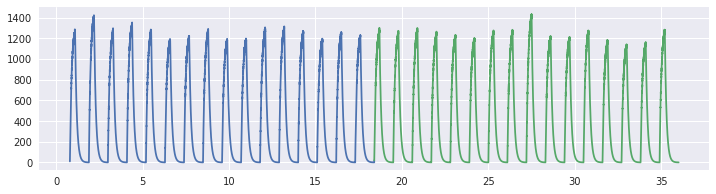

In [167]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])

In [168]:
columns = ("vec", "resp")

a1 = meg_sig[fan1_slc].flatten()
l1 = ["fan1"] * len(a1)
s1 = [True] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "inhib": s1})


a2 = meg_sig[fan2_slc].flatten()
l2 = ["fan2"] * len(a2)
s2 = [True] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "inhib": s2})

acts = pd.concat((p1, p2))

(300, 500)

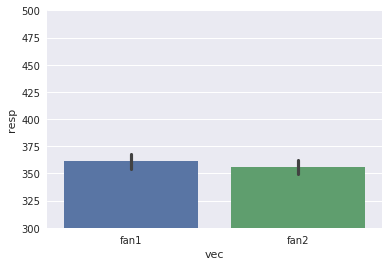

In [169]:
ax = sns.barplot(x="vec", y="resp", data=acts)
ax.set_ylim((300, 500))

In [170]:
activity_fan1 = sim.data[p_spikes][fan1_slc]
activity_fan2 = sim.data[p_spikes][fan2_slc]

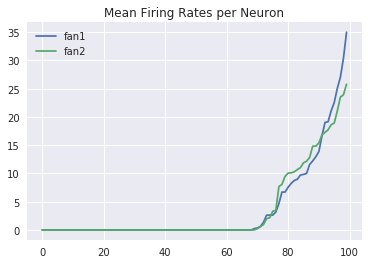

In [172]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_fan1, axis=0)), label="fan1")
plt.plot(np.sort(np.mean(activity_fan2, axis=0)), label="fan2")
#plt.plot(np.sort(np.mean(np.concatenate((activity_fan1, activity_fan2)), axis=0)), label="all trials")
plt.legend()

## Full Vocab

In [173]:
n_items = 16
dimensions = 32
n_neurons = 1000

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [174]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs
len(feed_vecs)

32

In [175]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e3

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions)
    
    nengo.Connection(in_nd, ens)
    nengo.Connection(paused, ens.neurons, transform=-1 * np.ones((n_neurons, 1)))
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    p_spikes = nengo.Probe(ens.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:31.                                                 


In [176]:
fan1_slc = slice(int(td_pause), int(t_each/dt)*len(fan1)+int(td_pause))
fan2_slc = slice(fan1_slc.stop, int(t_each/dt)*len(feed_vecs)+int(td_pause))

In [177]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

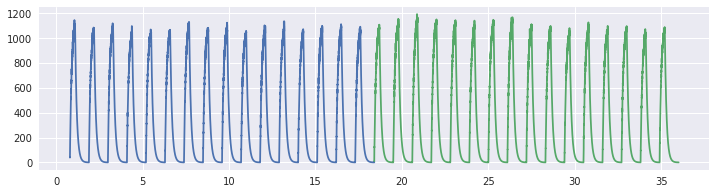

In [178]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])

In [179]:
columns = ("vec", "resp")

a1 = meg_sig[fan1_slc].flatten()
l1 = ["fan1"] * len(a1)
s1 = [True] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "inhib": s1})


a2 = meg_sig[fan2_slc].flatten()
l2 = ["fan2"] * len(a2)
s2 = [True] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "inhib": s2})

acts = pd.concat((p1, p2))

(300, 350)

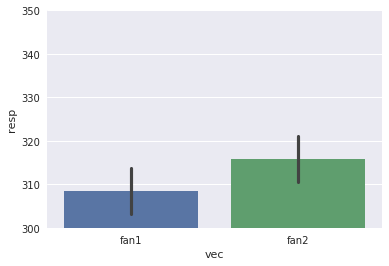

In [180]:
ax = sns.barplot(x="vec", y="resp", data=acts)
ax.set_ylim((300, 350))

In [181]:
activity_fan1 = sim.data[p_spikes][fan1_slc]
activity_fan2 = sim.data[p_spikes][fan2_slc]

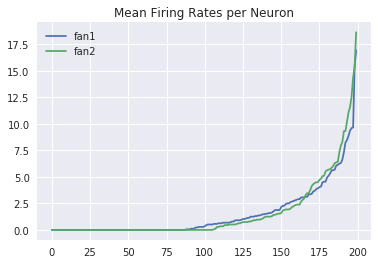

In [183]:
plt.title("Mean Firing Rates per Neuron")
plt.plot(np.sort(np.mean(activity_fan1, axis=0))[-200:], label="fan1")
plt.plot(np.sort(np.mean(activity_fan2, axis=0))[-200:], label="fan2")
#plt.plot(np.sort(np.mean(np.concatenate((activity_fan1, activity_fan2)), axis=0)), label="all trials")
plt.legend()

In [187]:
mean_act1 = np.mean(activity_fan1, axis=0)
mean_act2 = np.mean(activity_fan2, axis=0)
print(np.sum(mean_act1 > mean_act2))
print(np.sum(mean_act1 < mean_act2))

65
64


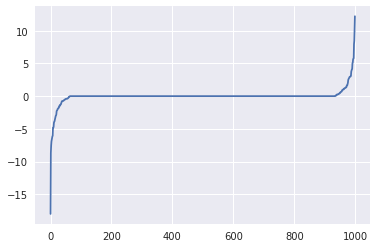

In [186]:
plt.plot(np.sort(mean_act1 - mean_act2))